# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


# Libraries and datasets

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from col_names import *
from utility import *

In [5]:
with open(f'{PICKLE_FOLDER}clustering_df.pkl', 'rb') as f:
    clustering_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_clustering_df.pkl', 'rb') as f:
    pure_clustering_df = pickle.load(f)

## K-Means

In [ ]:
# Sum of Squared Errors: cohesion measure
# silhouette score: both cohesion and separation measure
clustering_scores = pd.DataFrame(columns = ['silhouette', 'SSE'], dtype=float)

def store_clustering_scores(points, labels, algorithm_name):
    SSE = 0
    grouped = pd.DataFrame(points).groupby(pd.Series(labels))

    # computation of SSE
    for _, group in grouped:
        center = group.mean(axis=0)
        SSE += np.sum((group - center)**2).sum()
    clustering_scores.loc[algorithm_name, 'SSE'] = SSE
    
    # computation of silhouette score
    clustering_scores.loc[algorithm_name, 'silhouette'] = silhouette_score(points, labels)

In [3]:
clustering_df_array = StandardScaler().fit_transform(clustering_df)

In [ ]:
def elbow_rule(n_init=N_INIT, max_iter=MAX_ITER, max_k=MAX_K):
    sse_list = []

    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=1)
        kmeans.fit(clustering_df_array)
        sse = kmeans.inertia_
        sse_list.append(sse)

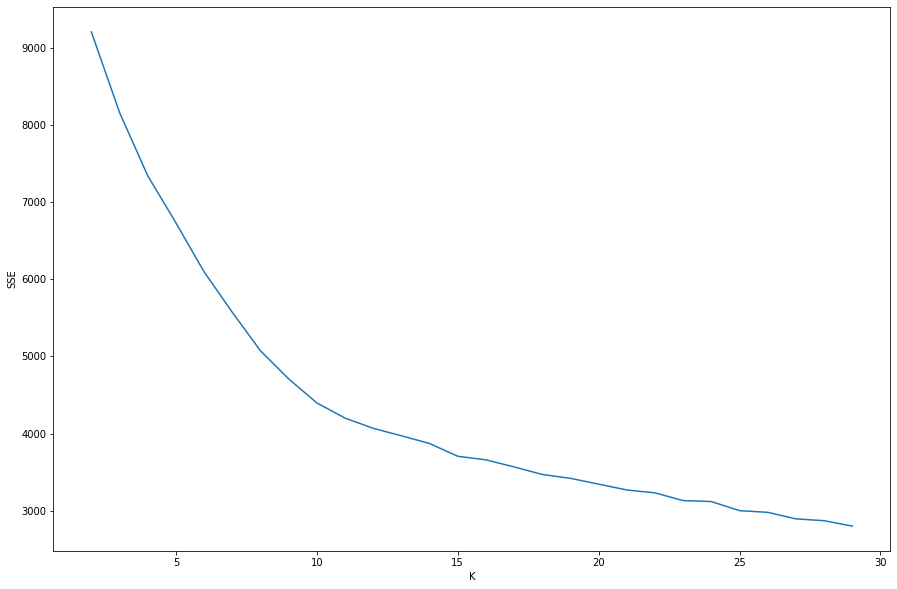

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(2, MAX_K), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major')
plt.show()

In [ ]:
def reoder_labels(labels, centers):
    # Rename clusters labels by cluster size
    renamed_labels = pd.Series(labels.astype(str))
    cluster_sizes = renamed_labels.value_counts()

    def to_new_label(old_label):
        return cluster_sizes.index.get_loc(old_label)

    for i in renamed_labels.index:
        renamed_labels[i] = to_new_label(renamed_labels[i])

    # Re-order the centers
    centers_copy = pd.DataFrame(centers)  # in case a np array was passed
    renamed_centers = np.zeros_like(centers)
    for i, center in centers_copy.iterrows():
        renamed_centers[to_new_label(str(i))] = center

    return renamed_labels, renamed_centers

In [ ]:
def plot_clusters(labels, centers, user_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(labels.astype('str').sort_values(), bins=10, ax=ax1)
    items_per_cluster = labels.value_counts()

    for i, center in enumerate(centers):
        if items_per_cluster.loc[i] > np.sqrt(items_per_cluster.nlargest(1).values):
            ax2.plot(center, range(len(user_df.columns)), marker='o', label='Cluster %s' % i)
    # ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_yticks(range(len(user_df.columns)))
    ax2.set_yticklabels(user_df.columns)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    plt.legend()
    plt.tight_layout()
    plt.show()

<Figure size 720x360 with 0 Axes>

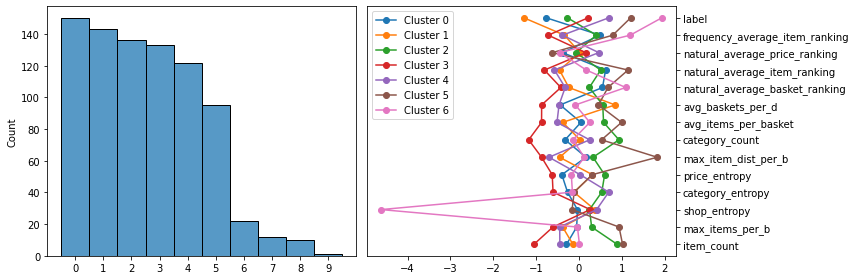

In [ ]:
kmeans = KMeans(n_clusters=10, n_init=50, max_iter=100, random_state=1)
kmeans.fit(clustering_df_array)
store_clustering_scores(clustering_df_array, kmeans.labels_, 'kmeans')
kmeans_labels, kmeans_centers = reoder_labels(kmeans.labels_, kmeans.cluster_centers_)
plt.figure(figsize=(10, 5))
plot_clusters(kmeans_labels, kmeans_centers, clustering_df)
plt.show()

/tmp/ipykernel_36454/1611675523.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  scatter = ax1.scatter(u_df[mask][IDCNT], u_df[mask][ABXVD], c=kmeans_labels[mask])
/tmp/ipykernel_36454/1611675523.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  scatter = ax2.scatter(u_df[mask][NABR], u_df[mask][NAIR], c=kmeans_labels[mask])
/tmp/ipykernel_36454/1611675523.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  scatter = ax3.scatter(u_df[mask][NABR], u_df[mask][NAPR], c=kmeans_labels[mask])


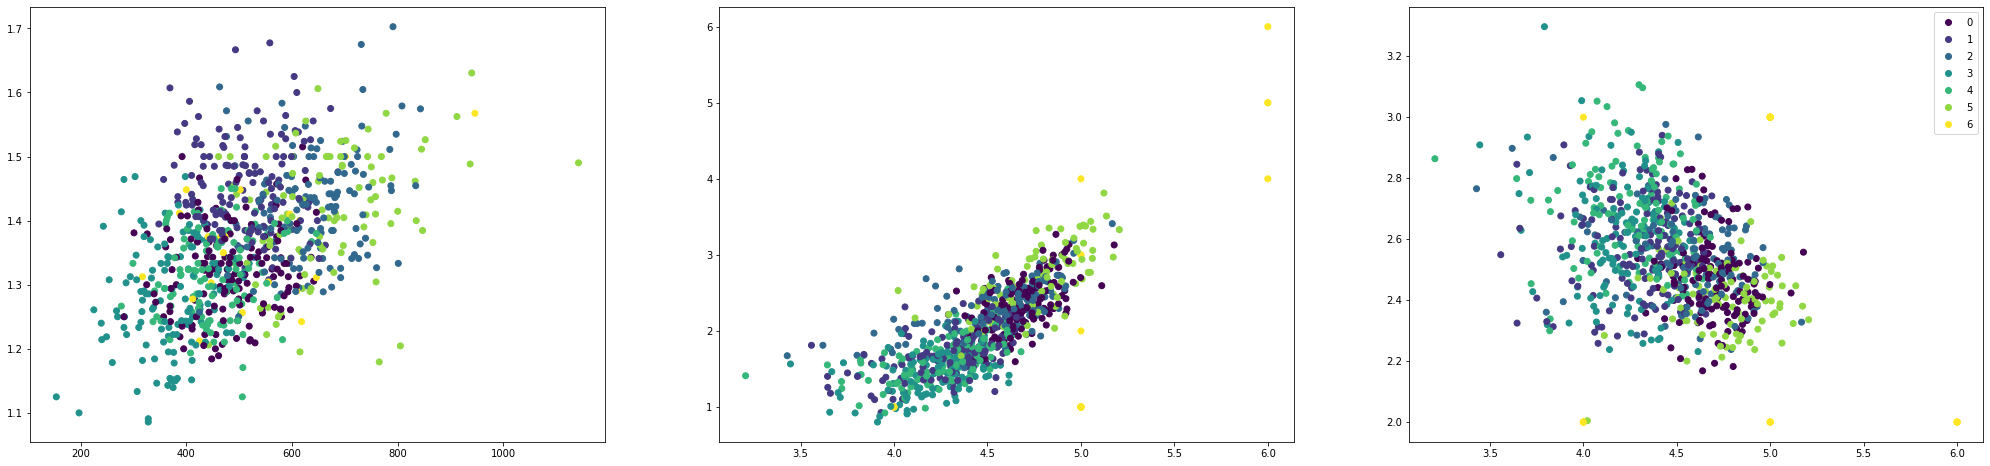

In [ ]:
# mask to remove points in outliers clusters
mask = (kmeans_labels < 6.5)
mask.index = range(1, len(mask)+1)
kmeans_labels.index = range(1, len(kmeans_labels)+1)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(35,8))

scatter = ax1.scatter(u_df[mask][IDCNT], u_df[mask][ABXVD], c=kmeans_labels[mask])

scatter = ax2.scatter(u_df[mask][NABR], u_df[mask][NAIR], c=kmeans_labels[mask])

scatter = ax3.scatter(u_df[mask][NABR], u_df[mask][NAPR], c=kmeans_labels[mask])

plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1, 1))

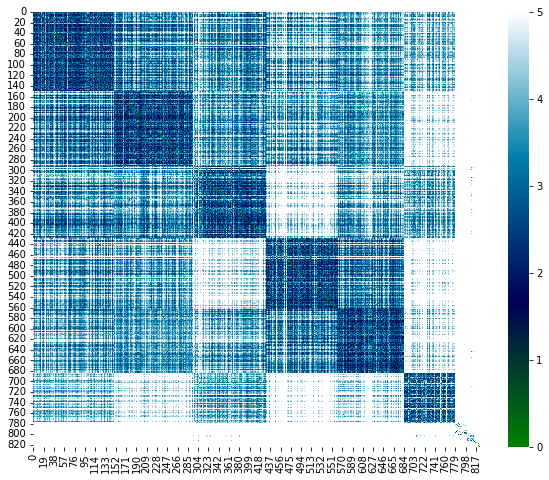

In [ ]:
distances = np.zeros((clustering_df_array.shape[0], clustering_df_array.shape[0]))
for i, x in enumerate(clustering_df_array):
    distances[i, :] = np.sqrt(np.sum((clustering_df_array - x) * (clustering_df_array - x), axis=1))
distances = distances[np.argsort(kmeans_labels), :]
distances = distances[:, np.argsort(kmeans_labels)]

fig, ax = plt.subplots(1, 1, figsize=(10,8))
sns.heatmap(np.clip(distances, 0, 5), ax=ax, cmap='ocean')
plt.show()

In [ ]:
u_df[LAB] = kmeans_labels

In [ ]:
u_df.groupby(LAB).mean()

,user_id,item_count,item_dist_count,max_items_per_b,shop_entropy,category_entropy,item_entropy,price_entropy,max_item_dist_per_b,total_price,...,category_count,shop_count,avg_items_per_basket,avg_baskets_per_d,natural_average_basket_ranking,natural_average_item_ranking,natural_average_price_ranking,frequency_average_basket_ranking,frequency_average_item_ranking,frequency_average_price_ranking
label,,,,,,,,,,,,,,,,,,,,,
0,389.573333,628.826667,484.406667,106.760000,2.684365,2.561335,6.143103,3.824286,81.893333,5.309762e+05,...,44.140000,26.620000,13.542652,1.322633,4.691537,2.369417,2.471670,4.705030,4.622531,2.554163
1,438.000000,660.657343,510.741259,77.860140,2.920262,2.577963,6.193946,3.979739,59.335664,5.797263e+05,...,45.706294,28.776224,12.173704,1.451109,4.309908,1.701575,2.570956,4.240448,4.176237,2.799263
2,410.419118,876.110294,635.022059,137.463235,2.849249,2.650340,6.410210,4.041740,87.823529,7.983063e+05,...,49.794118,30.051471,15.247976,1.422245,4.542313,2.298423,2.548854,4.551599,4.575457,2.722422
3,400.127820,469.902256,372.330827,58.015038,2.858625,2.523699,5.875793,3.775366,44.015038,4.104217e+05,...,40.315789,26.165414,10.586268,1.279354,4.219305,1.482814,2.604988,4.080033,3.973785,2.888187
4,419.114754,596.696721,456.040984,71.860656,2.946792,2.668495,6.081163,3.917562,50.377049,5.502124e+05,...,46.713115,28.762295,11.744387,1.320024,4.268373,1.628988,2.679800,4.204308,4.151684,3.008291
5,424.126316,901.673684,668.800000,193.778947,2.610673,2.578741,6.459113,3.978625,142.600000,7.570752e+05,...,47.968421,28.484211,16.601737,1.412332,4.753500,2.694801,2.413080,4.818723,4.781195,2.327327
6,411.863636,691.863636,520.727273,108.318182,0.000000,2.574034,6.199259,3.872459,80.454545,5.793420e+05,...,44.954545,1.000000,14.215330,1.358160,4.954545,2.090909,2.454545,5.136364,5.000000,2.727273
7,412.750000,1357.333333,643.750000,626.250000,2.743347,2.688874,6.405147,3.941339,135.416667,1.305943e+06,...,46.166667,29.416667,26.063127,1.379930,3.579214,1.616571,2.769315,3.580438,4.513162,3.346321
8,353.400000,749.600000,571.100000,105.700000,0.000000,2.584618,6.299638,3.963319,80.900000,6.520201e+05,...,47.200000,1.000000,14.076515,1.383248,1.800000,0.400000,3.600000,1.400000,2.100000,4.600000


In [ ]:
clustering_scores

,silhouette,SSE
kmeans,0.186508,4396.832076
